<a href="https://colab.research.google.com/github/mbabar1100/CSCI5952GenerativeImputationOfMissingOmics/blob/main/Big_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import pandas as pd
url = "https://raw.githubusercontent.com/instadeepai/multiomics-open-research/main/data/bulkrnabert/tcga_sample.csv"
df = pd.read_csv(url)

In [4]:

#Install the GDC Data Transfer Tool
!wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip -O gdc-client.zip
!unzip gdc-client.zip
!chmod +x gdc-client

--2025-10-23 21:00:28--  https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip
Resolving gdc.cancer.gov (gdc.cancer.gov)... 34.197.116.243, 54.197.167.184
Connecting to gdc.cancer.gov (gdc.cancer.gov)|34.197.116.243|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://gdc.cancer.gov:443/system/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip [following]
--2025-10-23 21:00:28--  https://gdc.cancer.gov/system/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip
Reusing existing connection to gdc.cancer.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 23940006 (23M) [application/zip]
Saving to: ‘gdc-client.zip’

gdc-client.zip      100%[===================>]  22.83M  50.4MB/s    in 0.5s    

2025-10-23 21:00:29 (50.4 MB/s) - ‘gdc-client.zip’ saved [23940006/23940006]

Archive:  gdc-client.zip
 extracting: gdc-client              


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

# Create a folder in Drive to store TCGA data
data_dir = "/content/drive/MyDrive/Colab Notebooks/TCGA_data"
os.makedirs(data_dir, exist_ok=True)

print("Data directory created at:", data_dir)

Data directory created at: /content/drive/MyDrive/Colab Notebooks/TCGA_data


In [8]:
import os
import pandas as pd

# Step 1: Define base directory in your Google Drive (for saving outputs)
base_dir = "/content/drive/MyDrive/Colab Notebooks/TCGA_data"
output_dir = os.path.join(base_dir, "merged_batches")
os.makedirs(output_dir, exist_ok=True)

# Step 2: TCGA transcriptomics dataset URL (from GitHub raw)
url = "https://raw.githubusercontent.com/instadeepai/multiomics-open-research/main/data/bulkrnabert/tcga_sample.csv"

# Step 3: Load the dataset
try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully!")
    print("Shape:", df.shape)
    print(df.head(3))
except Exception as e:
    print("Error loading dataset:", e)

# Step 4: Add a modality label (for consistency with multi-omics structure)
df['modality'] = "transcriptomics"

# Step 5: Add a sample_id column if it’s missing
if 'sample_id' not in df.columns:
    df['sample_id'] = df.index

# Step 6: Save as a Parquet file for efficient storage
output_file = os.path.join(output_dir, "transcriptomics_tcga_sample.parquet")
df.to_parquet(output_file)
print(f"Saved processed file to: {output_file}")




Dataset loaded successfully!
Shape: (4, 19063)
   ENSG00000000003  ENSG00000000005  ENSG00000000419  ENSG00000000457  \
0          69.5439           0.4599         112.2372           8.4532   
1          55.2986           1.8746          51.8722           4.8353   
2           5.8836           1.3023         115.9459           6.9493   

   ENSG00000000460  ENSG00000000938  ENSG00000000971  ENSG00000001036  \
0           8.4303          19.1823           7.8015          62.8843   
1           4.0387          12.6223          12.9179          38.7700   
2           4.3589           6.8639           2.4921          30.7555   

   ENSG00000001084  ENSG00000001167  ...  ENSG00000284532  ENSG00000284535  \
0          19.1064          31.7049  ...              0.0              0.0   
1          12.1175          15.9724  ...              0.0              0.0   
2          17.7058          19.6703  ...              0.0              0.0   

   ENSG00000284543  ENSG00000284557  ENSG00000284564  

In [16]:
import os
import pandas as pd
from glob import glob

# Paths
base_dir = "/content/drive/MyDrive/Colab Notebooks/TCGA_data"
merged_batches_dir = os.path.join(base_dir, "merged_batches")
imputation_ready_dir = os.path.join(base_dir, "imputation_ready")
os.makedirs(imputation_ready_dir, exist_ok=True)

# Define column patterns per modality
modality_patterns = {
    "genomics": ["copy_number", "min_copy_number", "max_copy_number", "mutation"],
    "transcriptomics": ["tpm", "fpkm", "gene", "expression"],
    "clinical": ["age", "gender", "tumor_stage", "vital_status", "days_to_death", "days_to_last_followup"]
}

# Function to detect columns for each modality
def detect_modality_columns(df, modality_patterns):
    detected = {}
    for modality, patterns in modality_patterns.items():
        matched_cols = [c for c in df.columns if any(p in c.lower() for p in patterns)]
        detected[modality] = matched_cols
    return detected

# Load available Parquet files from Step 6
batch_files = sorted(glob(os.path.join(merged_batches_dir, "*.parquet")))

if not batch_files:
    print("No Parquet files found in merged_batches_dir. Make sure Step 6 ran successfully.")
else:
    for batch_file in batch_files:
        print(f"\n Loading batch: {batch_file}")
        df = pd.read_parquet(batch_file)

        # Detect columns per modality
        detected_columns = detect_modality_columns(df, modality_patterns)
        print(f"Detected columns per modality:\n{detected_columns}")

        # For transcriptomics-only dataset
        transcriptomics_cols = detected_columns.get("transcriptomics", [])
        if not transcriptomics_cols:
            print("No transcriptomics columns detected, saving full dataset instead.")
            transcriptomics_cols = df.columns.tolist()

        # Include sample_id if present
        if "sample_id" in df.columns and "sample_id" not in transcriptomics_cols:
            transcriptomics_cols.append("sample_id")

        # Subset and save transcriptomics data
        transcriptomics_df = df[transcriptomics_cols]
        out_file = os.path.join(imputation_ready_dir, f"transcriptomics_imputation_ready.parquet")
        transcriptomics_df.to_parquet(out_file, index=False)
        print(f"Saved imputation-ready transcriptomics data to:\n{out_file}")

print("\n Step 7 complete: Transcriptomics data prepared and ready for imputation.")



 Loading batch: /content/drive/MyDrive/Colab Notebooks/TCGA_data/merged_batches/transcriptomics_tcga_sample.parquet
Detected columns per modality:
{'genomics': [], 'transcriptomics': [], 'clinical': []}
No transcriptomics columns detected, saving full dataset instead.
Saved imputation-ready transcriptomics data to:
/content/drive/MyDrive/Colab Notebooks/TCGA_data/imputation_ready/transcriptomics_imputation_ready.parquet

 Step 7 complete: Transcriptomics data prepared and ready for imputation.


In [12]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
import os

expr_file = "/content/drive/MyDrive/Colab Notebooks/TCGA_data/imputation_ready/transcriptomics_imputation_ready.parquet"
output_dir = "/content/drive/MyDrive/Colab Notebooks/TCGA_data/imputation_ready"
expr_df = pd.read_parquet(expr_file)
print("Loaded transcriptomics data")
print(expr_df.shape)
print(expr_df.head(3))

expr_numeric = expr_df.select_dtypes(include=[np.number])
print(f"Numeric columns before cleaning: {expr_numeric.shape[1]}")

expr_numeric_clean = expr_numeric.dropna(axis=1, how='all')
print(f"Columns after dropping all-NaN: {expr_numeric_clean.shape[1]}")

X = expr_numeric_clean.to_numpy().copy()
mask = np.random.rand(*X.shape) < 0.1  # 10% missing
X[mask] = np.nan
print(f"Introduced missing values: {np.isnan(X).sum()} entries masked")

knn_imputer = KNNImputer(n_neighbors=5)
X_knn_imputed = knn_imputer.fit_transform(X)
print("KNN imputation complete")

mean_imputer = SimpleImputer(strategy="mean")
X_mean_imputed = mean_imputer.fit_transform(X)
print("Mean imputation complete")

df_knn = pd.DataFrame(X_knn_imputed, columns=expr_numeric_clean.columns, index=expr_numeric_clean.index)
df_mean = pd.DataFrame(X_mean_imputed, columns=expr_numeric_clean.columns, index=expr_numeric_clean.index)

os.makedirs(output_dir, exist_ok=True)
df_knn.to_parquet(os.path.join(output_dir, "transcriptomics_knn_imputed.parquet"), index=False)
df_mean.to_parquet(os.path.join(output_dir, "transcriptomics_mean_imputed.parquet"), index=False)
print(f"Imputed files saved to: {output_dir}")


Loaded transcriptomics data
(4, 19065)
   ENSG00000000003  ENSG00000000005  ENSG00000000419  ENSG00000000457  \
0          69.5439           0.4599         112.2372           8.4532   
1          55.2986           1.8746          51.8722           4.8353   
2           5.8836           1.3023         115.9459           6.9493   

   ENSG00000000460  ENSG00000000938  ENSG00000000971  ENSG00000001036  \
0           8.4303          19.1823           7.8015          62.8843   
1           4.0387          12.6223          12.9179          38.7700   
2           4.3589           6.8639           2.4921          30.7555   

   ENSG00000001084  ENSG00000001167  ...  ENSG00000284543  ENSG00000284557  \
0          19.1064          31.7049  ...           0.0492              0.0   
1          12.1175          15.9724  ...           0.0080              0.0   
2          17.7058          19.6703  ...           0.0075              0.0   

   ENSG00000284564  ENSG00000284574  ENSG00000284587  ENSG0000

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os

expr_file = "/content/drive/MyDrive/Colab Notebooks/TCGA_data/imputation_ready/transcriptomics_imputation_ready.parquet"
expr_df = pd.read_parquet(expr_file)
expr_numeric = expr_df.select_dtypes(include=[np.number]).dropna(axis=1, how='all')
X = expr_numeric.to_numpy()
print("Data loaded:", X.shape)

X_tensor = torch.tensor(np.nan_to_num(X), dtype=torch.float32)

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

input_dim = X_tensor.shape[1]
model = Autoencoder(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

X_tensor = X_tensor.to(device)

epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, X_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    X_imputed = model(X_tensor).cpu().numpy()

# Restore NaNs only for positions that were missing originally
nan_mask = np.isnan(X)
X_imputed[nan_mask] = X_imputed[nan_mask]

# Convert back to DataFrame
df_imputed = pd.DataFrame(X_imputed, columns=expr_numeric.columns, index=expr_numeric.index)

output_dir = "/content/drive/MyDrive/Colab Notebooks/TCGA_data/imputation_ready"
os.makedirs(output_dir, exist_ok=True)
df_imputed.to_parquet(os.path.join(output_dir, "transcriptomics_autoencoder_imputed.parquet"), index=False)
print(f"Autoencoder-imputed data saved to {output_dir}")


Data loaded: (4, 19063)
Using device: cpu
Epoch [5/20], Loss: 35940.222656
Epoch [10/20], Loss: 26491.744141
Epoch [15/20], Loss: 18470.142578
Epoch [20/20], Loss: 13491.131836
Autoencoder-imputed data saved to /content/drive/MyDrive/Colab Notebooks/TCGA_data/imputation_ready


In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Create mask for observed entries (non-NaN in original X)
observed_mask = ~np.isnan(X)
rmse_knn = np.sqrt(mean_squared_error(X[observed_mask], X_knn_imputed[observed_mask]))
rmse_mean = np.sqrt(mean_squared_error(X[observed_mask], X_mean_imputed[observed_mask]))

corr_knn, _ = pearsonr(X[observed_mask].flatten(), X_knn_imputed[observed_mask].flatten())
corr_mean, _ = pearsonr(X[observed_mask].flatten(), X_mean_imputed[observed_mask].flatten())

print(f"KNN Imputation -> RMSE: {rmse_knn:.4f}, Pearson: {corr_knn:.4f}")
print(f"Mean Imputation -> RMSE: {rmse_mean:.4f}, Pearson: {corr_mean:.4f}")


KNN Imputation -> RMSE: 34.6324, Pearson: 0.9839
Mean Imputation -> RMSE: 34.6324, Pearson: 0.9839


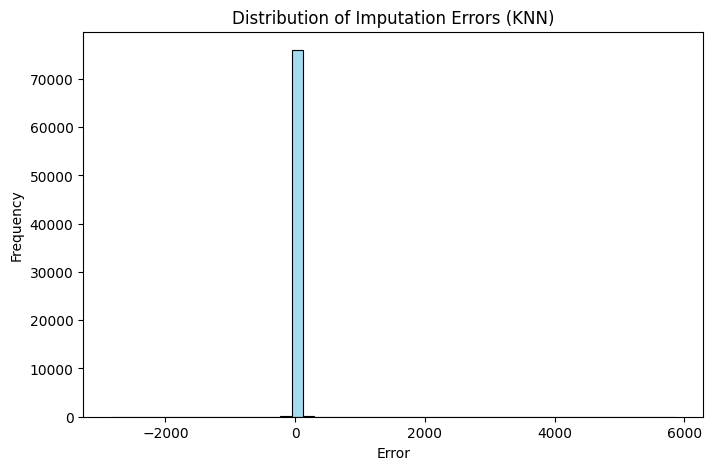

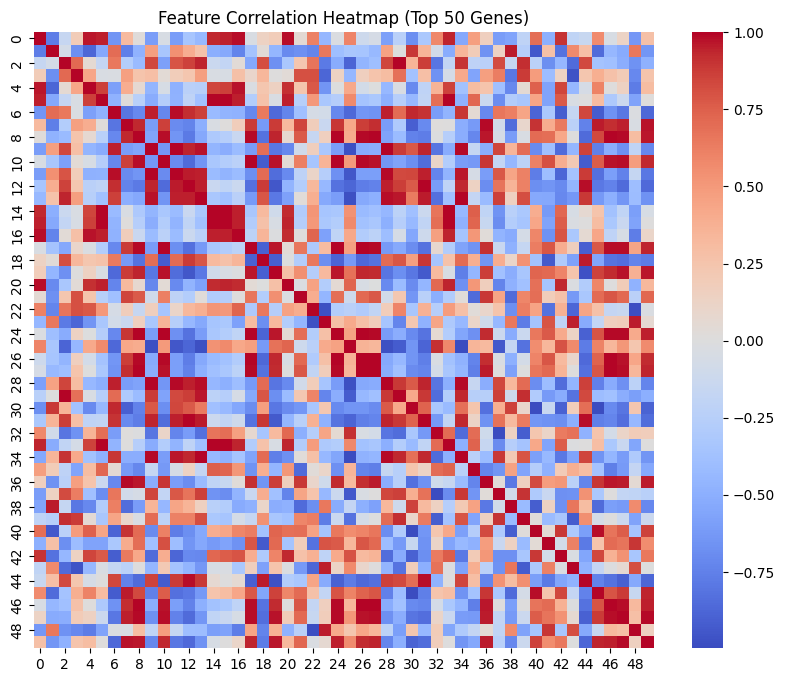

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

observed_mask = ~np.isnan(X)
errors = (X[observed_mask] - X_knn_imputed[observed_mask]).flatten()

# Error distribution plot
plt.figure(figsize=(8,5))
sns.histplot(errors, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Imputation Errors (KNN)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# For large datasets, use top 50 most variable features for visualization
variances = X_knn_imputed.var(axis=0)
top_idx = np.argsort(variances)[-50:]  # indices of top 50 variable features
corr_matrix = np.corrcoef(X_knn_imputed[:, top_idx].T)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (Top 50 Genes)")
plt.show()
